# Scatter Plot Visualization Data

Lets Try:

- Put all the LOI's on a single 2D plot
- Each point represents an LOI document
- The coordinates of the point are from some sort of clustering
- The color of the point is the area it was submitted to
- Mouse over gets you some "intersting" metadata:
   - The filename
   - The first 100 characters of text
   - An active link to the PDF

In order to do this we need to generate a bunch of data and write it out in a CSV file.

## Config

In [14]:
n_features = 3000
n_components = 2
n_word_summary = 100

## Setup

In [2]:
from config import text_file_info, extra_stopwords

# from collections import defaultdict
from pathlib import Path

# from sklearn.feature_extraction.text import HashingVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import _check_stop_list
# from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA
# from sklearn.decomposition import TruncatedSVD
# from sklearn.preprocessing import Normalizer
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import numpy as np

stopwords = list(_check_stop_list('english')) + extra_stopwords

## Files

In [3]:
file_by_area = list(text_file_info())

In [4]:
data_filenames = [f[2] for f in file_by_area]
file_names = [f[0] for f in file_by_area]
file_areas = [f[1] for f in file_by_area]

## Text

We want the first n words of text from each file. Grab them here.

In [17]:
file_text_summary = [' '.join(Path(f).read_text().split()[:n_word_summary]) for f in data_filenames]

## 2D Coordinates from Text Contents

In [5]:
vectorizer = TfidfVectorizer(input='filename',
                             max_df=0.5, max_features=n_features,
                             min_df=2, stop_words=stopwords,
                             use_idf=True)

In [6]:
%%time
x = vectorizer.fit_transform(data_filenames)

CPU times: user 3.61 s, sys: 1.5 s, total: 5.11 s
Wall time: 23.6 s


Now we do the Principle Component Analysis

In [7]:
pca = PCA(n_components)

In [8]:
%%time
loi_coordinates = pca.fit_transform(x.A)

CPU times: user 1.6 s, sys: 1.39 s, total: 2.99 s
Wall time: 475 ms


Lets use `seaborn` to make a plot of this.

In [19]:
document_data = [
    {
        'x': x,
        'y': y,
        'name': str(name),
        'area': str(area),
        'url': f'http://faculty.washington.edu/gwatts/snowmass-loi/{area}/{name}.pdf',
        'summary': str(summary)
    }
    for (x, y), name, area, summary in zip(loi_coordinates, file_names, file_areas, file_text_summary)
]
document_df = pd.DataFrame(document_data)

In [20]:
document_df

,x,y,name,area,url,summary
0,-0.085025,-0.059940,SNOWMASS21-AF-TOPIC0-001,AF,http://faculty.washington.edu/gwatts/snowmass-...,"May 21, 2020 Gamma Factory L ETTER OF I NTERES..."
1,-0.132215,-0.151574,SNOWMASS21-AF0-015,AF,http://faculty.washington.edu/gwatts/snowmass-...,"July 30th ,2020 2020 snowmass Letter of Intere..."
2,-0.059559,-0.100146,SNOWMASS21-AF0_AF0-091,AF,http://faculty.washington.edu/gwatts/snowmass-...,POTENTIAL FOR HIGH-ENERGY PHYSICS AT THE OAK R...
3,-0.147004,-0.231071,SNOWMASS21-AF0_AF0-215,AF,http://faculty.washington.edu/gwatts/snowmass-...,Plasma Processing for In-Situ Field Emission M...
4,-0.172486,-0.185640,SNOWMASS21-AF0_AF0-229,AF,http://faculty.washington.edu/gwatts/snowmass-...,Letter of Interest for Snowmass2021: R&D on Hi...
...,...,...,...,...,...,...
1561,-0.017209,-0.096514,SNOWMASS21-UF0_UF0_Garcia-Sciveres-001,UF,http://faculty.washington.edu/gwatts/snowmass-...,Snowmass2021 Letter of Interest: Classificatio...
1562,-0.015406,-0.083349,SNOWMASS21-UF1_UF4-RF4_RF3_ODonnell-007,UF,http://faculty.washington.edu/gwatts/snowmass-...,KURF: The Kimballton Underground Research Faci...
1563,0.168470,-0.075019,SNOWMASS21-UF4_UF3-NF5_NF6-CF1_CF0-IF3_IF0-Com...,UF,http://faculty.washington.edu/gwatts/snowmass-...,Snowmass2021 - Letter of Interest Advanced Ger...
1564,0.062493,-0.085960,SNOWMASS21-UF6_UF0-NF10_NF0-RF4_RF0-CF1_CF0-IF...,UF,http://faculty.washington.edu/gwatts/snowmass-...,Snowmass2021 - Letter of Interest Solution-min...


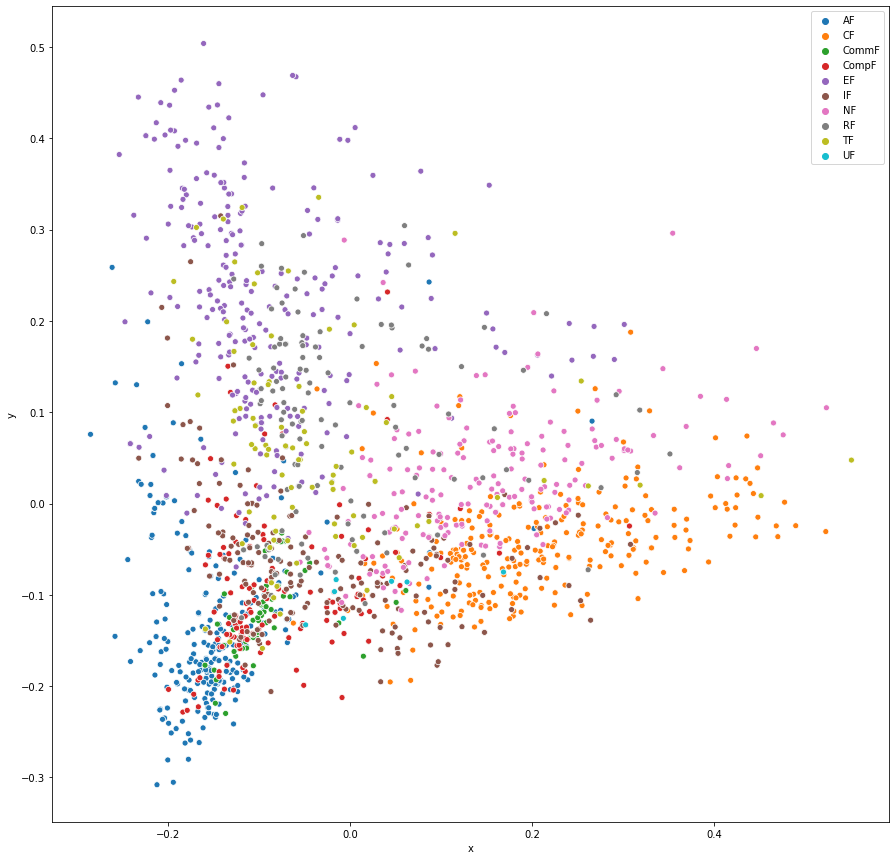

In [12]:
plt.figure(figsize=(15,15))
g = sns.scatterplot(x='x', y='y', hue=document_df.area.to_list(), data=document_df)

## Writing out the data

In [21]:
document_df.to_csv('loi-data.csv')